In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define dataset path (change this path to your dataset folder)
dataset_path = "C:/Users/inafe/OneDrive/Desktop/Plants - Copy"

# Initialize lists to store image resolutions
image_heights = []
image_widths = []


# Loop through each fruit category folder
for fruit_class in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, fruit_class)
    if os.path.isdir(class_folder):
        for image_file in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_file)
            img = cv2.imread(image_path)
            if img is not None:
                height, width = img.shape[:2]
                image_heights.append(height)
                image_widths.append(width)

# Convert lists to NumPy arrays
image_heights = np.array(image_heights)
image_widths = np.array(image_widths)

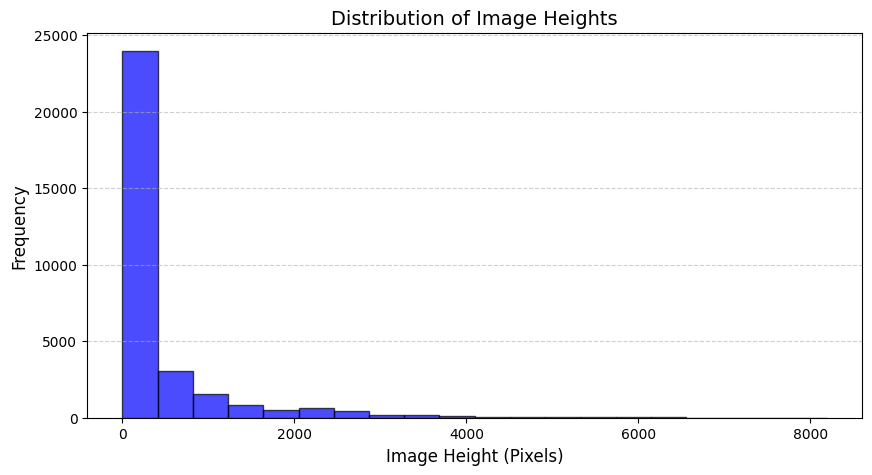

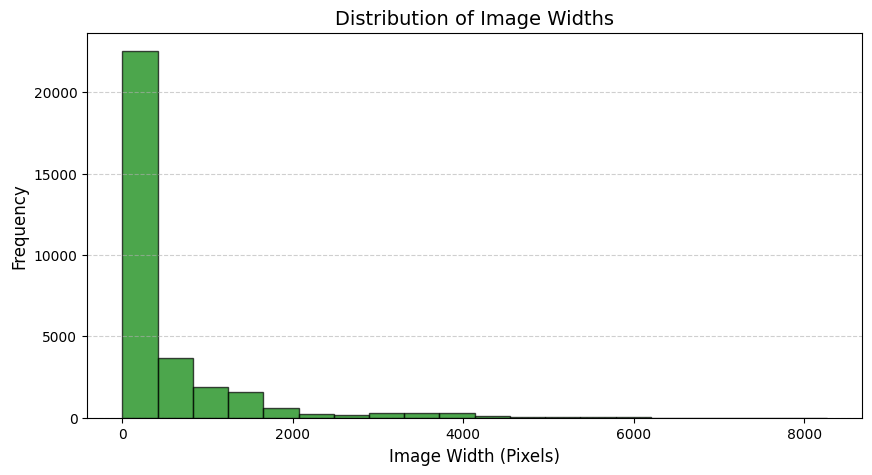

In [10]:
# --- Histogram for Image Heights ---
plt.figure(figsize=(10, 5))
plt.hist(image_heights, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Image Height (Pixels)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Image Heights", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# --- Histogram for Image Widths ---
plt.figure(figsize=(10, 5))
plt.hist(image_widths, bins=20, color='green', edgecolor='black', alpha=0.7)
plt.xlabel("Image Width (Pixels)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Image Widths", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

<positron-console-cell-7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



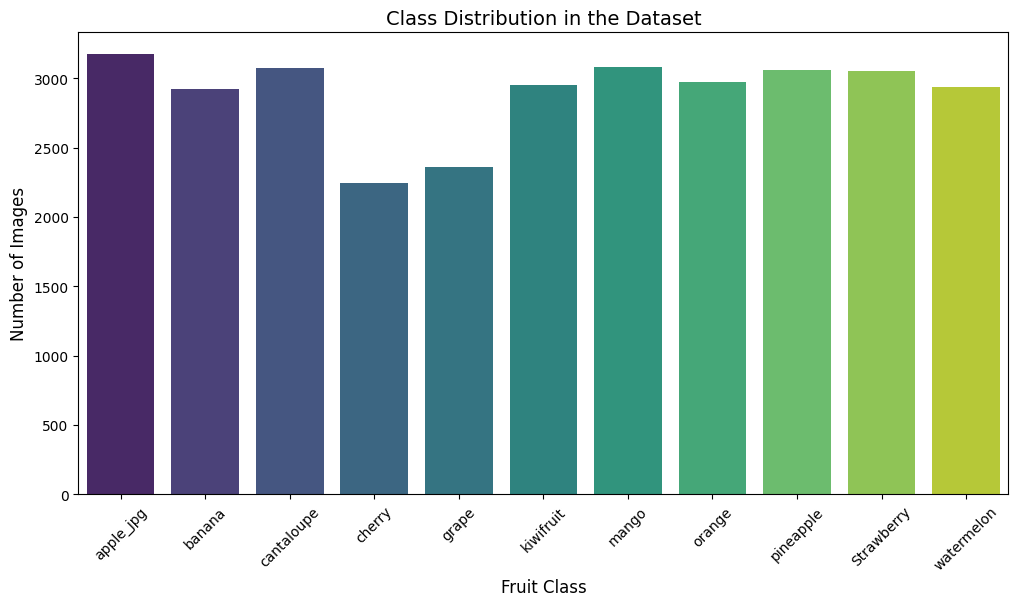

In [7]:
# --- Class Imbalance Analysis ---
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.xlabel("Fruit Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class Distribution in the Dataset", fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [6]:
# Print basic statistics on image resolutions
print(f"Mean Resolution: {np.mean(image_resolutions, axis=0)}")
print(f"Min Resolution: {np.min(image_resolutions, axis=0)}")
print(f"Max Resolution: {np.max(image_resolutions, axis=0)}")


Mean Resolution: [591.38302421 519.27777428]
Min Resolution: [1 1]
Max Resolution: [8268 8192]


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import os
# Verify GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


In [5]:
# Define data paths
data_dir = 'C:/Users/inafe/OneDrive/Desktop/Plants - Copy'
checkpoint_dir = 'checkpoints'  # Directory to save checkpoints

# Create checkpoint directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


In [6]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # MobileNet default size
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 25457 images belonging to 11 classes.
Found 6359 images belonging to 11 classes.


In [12]:
# Model architecture
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [13]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Calculate steps per epoch
steps_per_epoch = int(np.ceil(train_generator.samples / train_generator.batch_size))
validation_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))


In [14]:
# Create callbacks
# 1. ModelCheckpoint - saves model after each epoch
checkpoint_path = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.h5')
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,  # Only save when validation accuracy improves
    save_weights_only=False,  # Save entire model
    mode='max',
    verbose=1
)

# 2. Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop after 3 epochs without improvement
    restore_best_weights=True,
    verbose=1
)

In [15]:
# Train the model with checkpoints
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10,
    verbose=1,
    callbacks=[checkpoint_callback, early_stopping]
)

C:\Users\inafe\miniconda3\envs\pyv3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
  9/796 ━━━━━━━━━━━━━━━━━━━━ 27:32 2s/step - accuracy: 0.1747 - loss: 2.7156

C:\Users\inafe\miniconda3\envs\pyv3\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


796/796 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7149 - loss: 0.9054
Epoch 1: val_accuracy improved from -inf to 0.86444, saving model to checkpoints\model_epoch_01_val_acc_0.8644.h5
796/796 ━━━━━━━━━━━━━━━━━━━━ 2303s 3s/step - accuracy: 0.7150 - loss: 0.9051 - val_accuracy: 0.8644 - val_loss: 0.4171
Epoch 2/10
796/796 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8282 - loss: 0.5177
Epoch 2: val_accuracy improved from 0.86444 to 0.88111, saving model to checkpoints\model_epoch_02_val_acc_0.8811.h5
796/796 ━━━━━━━━━━━━━━━━━━━━ 1971s 2s/step - accuracy: 0.8282 - loss: 0.5177 - val_accuracy: 0.8811 - val_loss: 0.3460
Epoch 3/10
796/796 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8528 - loss: 0.4415
Epoch 3: val_accuracy improved from 0.88111 to 0.89511, saving model to checkpoints\model_epoch_03_val_acc_0.8951.h5
796/796 ━━━━━━━━━━━━━━━━━━━━ 1930s 2s/step - accuracy: 0.8528 - loss: 0.4415 - val_accuracy: 0.8951 - val_loss: 0.3211
Epoch 4/10
796/796 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step 

In [16]:
# Save the final model
final_model_path = os.path.join(checkpoint_dir, 'final_model.h5')
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

# To save training history as well
import pickle
history_path = os.path.join(checkpoint_dir, 'training_history.pkl')
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)
print(f"Training history saved to {history_path}")

Final model saved to checkpoints\final_model.h5
Training history saved to checkpoints\training_history.pkl


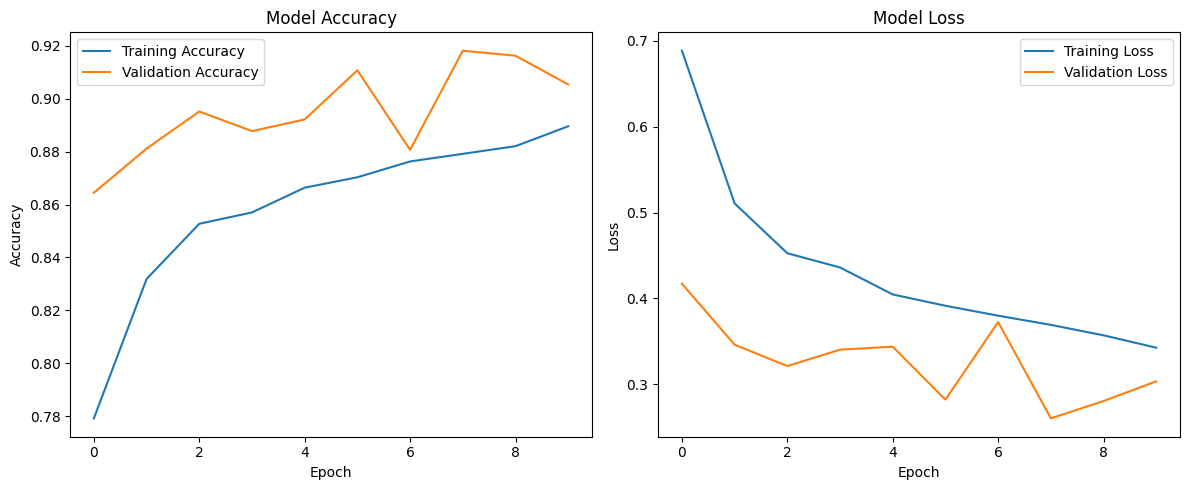

In [17]:
import matplotlib.pyplot as plt
import pickle
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Path to your saved history file
history_path = os.path.join('checkpoints', 'training_history.pkl')

# If you don't have the history saved, but you have the history object from training
# You can use: history = your_training_history_object

# Load the history file
try:
    with open(history_path, 'rb') as file:
        history = pickle.load(file)
    
    # Plot the training and validation accuracy
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()
    
except FileNotFoundError:
    print(f"History file not found at {history_path}. Please provide the correct path.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


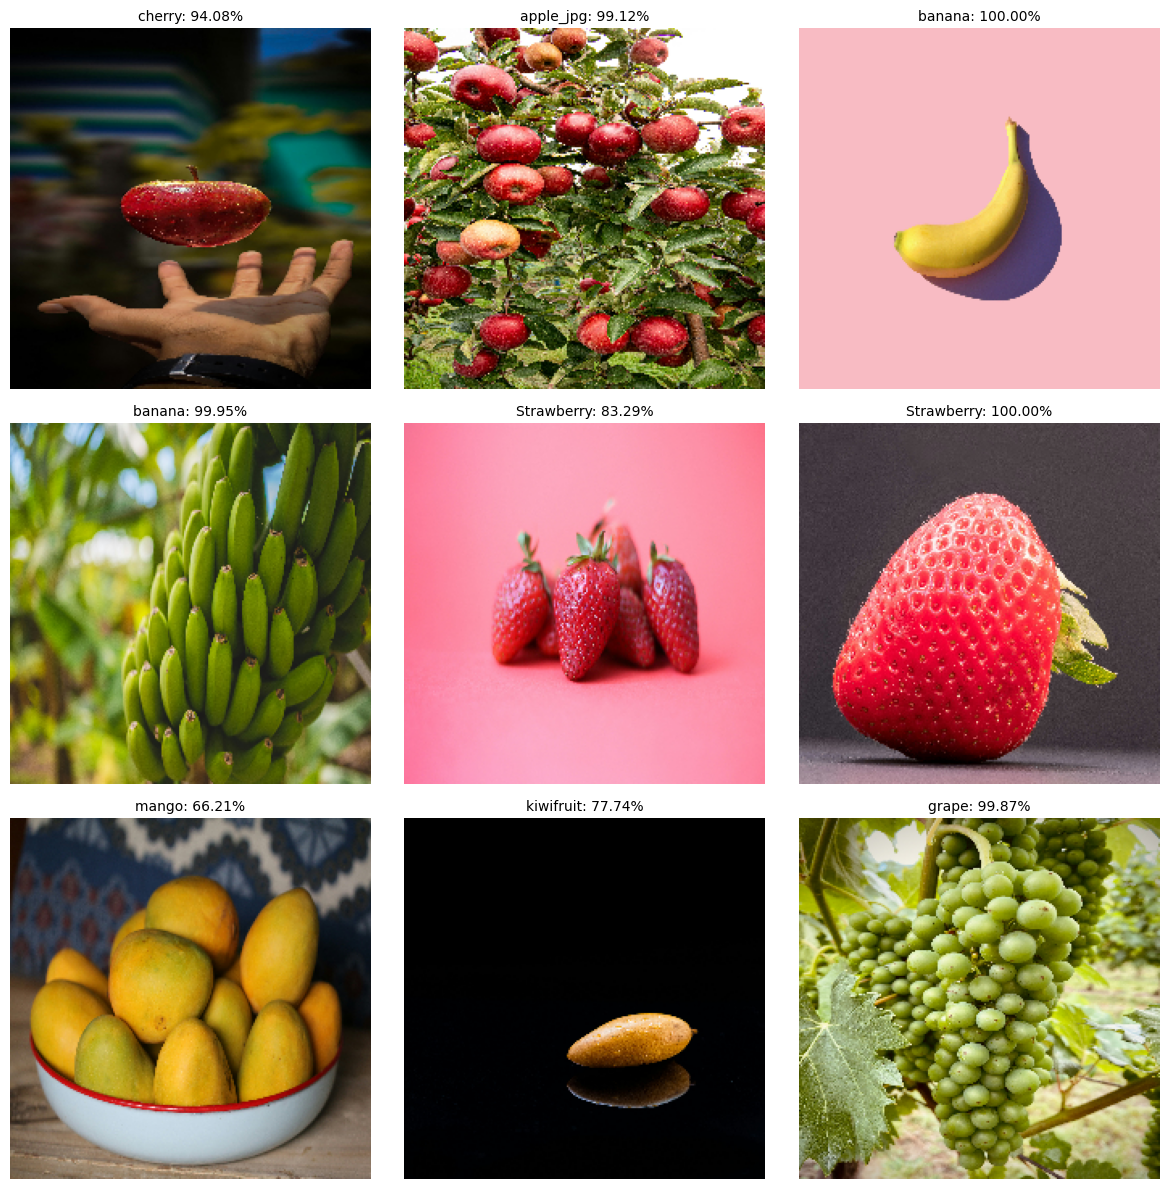


Predictions for Apple_p.jpg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
  cherry: 94.08%
  apple_jpg: 4.95%
  Strawberry: 0.48%

Predictions for Apple_p2.jpg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
  apple_jpg: 99.12%
  cherry: 0.67%
  Strawberry: 0.21%

Predictions for Banana_p.jpg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
  banana: 100.00%
  cantaloupe: 0.00%
  kiwifruit: 0.00%

Predictions for Banana_p2.jpg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
  banana: 99.95%
  grape: 0.02%
  kiwifruit: 0.02%

Predictions for Strawberry_p.jpg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
  Strawberry: 83.29%
  cherry: 16.59%
  apple_jpg: 0.09%

Predictions for Strawberry_p2.jpg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
  Strawberry: 100.00%
  cherry: 0.00%
  apple_jpg: 0.00%

Predictions for Mango_p.jpg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
  mango: 66.21%
  apple_jpg: 20.61%
  orange: 5.83%

Predictions for Mango_p2.jpg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
  kiwifruit: 77.74%
  banana: 14.43%
  apple_j

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load the trained model
model_path = os.path.join('checkpoints', 'final_model.h5')  # or your best checkpoint
model = tf.keras.models.load_model(model_path)

# Get class names from your training directory
data_dir = 'C:/Users/inafe/OneDrive/Desktop/Plants - Copy'  # Update this to your dataset path
class_names = sorted(os.listdir(data_dir))

# Function to preprocess and predict an image
def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Make prediction
    predictions = model.predict(img_array)
    
    # Get the top 3 predictions
    top_indices = predictions[0].argsort()[-3:][::-1]
    top_values = predictions[0][top_indices]
    
    # Return results
    results = [(class_names[idx], float(val) * 100) for idx, val in zip(top_indices, top_values)]
    return results, img

# Predict on multiple test images
def predict_multiple_images(test_image_paths):
    plt.figure(figsize=(12, 12))
    
    for i, img_path in enumerate(test_image_paths):
        if i >= 9:  # Limit to 9 images for display
            break
            
        predictions, img = predict_image(img_path)
        
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        
        # Display the top prediction
        title = f"{predictions[0][0]}: {predictions[0][1]:.2f}%"
        plt.title(title, fontsize=10)
    
    plt.tight_layout()
    plt.savefig('predictions.png')
    plt.show()
    
    # Print detailed results for each image
    for i, img_path in enumerate(test_image_paths):
        if i >= 9:
            break
            
        print(f"\nPredictions for {os.path.basename(img_path)}:")
        predictions, _ = predict_image(img_path)
        for class_name, confidence in predictions:
            print(f"  {class_name}: {confidence:.2f}%")

# Example usage:
# Replace these paths with paths to your unseen test images
test_images = [
    'D:/Download/Apple_p.jpg',
    'D:/Download/Apple_p2.jpg',
    'D:/Download/Banana_p.jpg',
    'D:/Download/Banana_p.jpg',
    'D:/Download/Strawberry_p.jpg',
    'D:/Download/Strawberry_p2.jpg',
    'D:/Download/Mango_p.jpg',
    'D:/Download/Mango_p2.jpg',
    'D:/Download/Grapes_p.jpg'
    # Add more test images here
]

# Run predictions
predict_multiple_images(test_images)

In [12]:
print("predictions.png")

predictions.png


In [9]:
model_path = os.path.join('checkpoints', 'final_model.h5')  # or your best checkpoint
model = tf.keras.models.load_model(model_path)

Found 6359 images belonging to 11 classes.


C:\Users\inafe\miniconda3\envs\pyv3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


199/199 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step


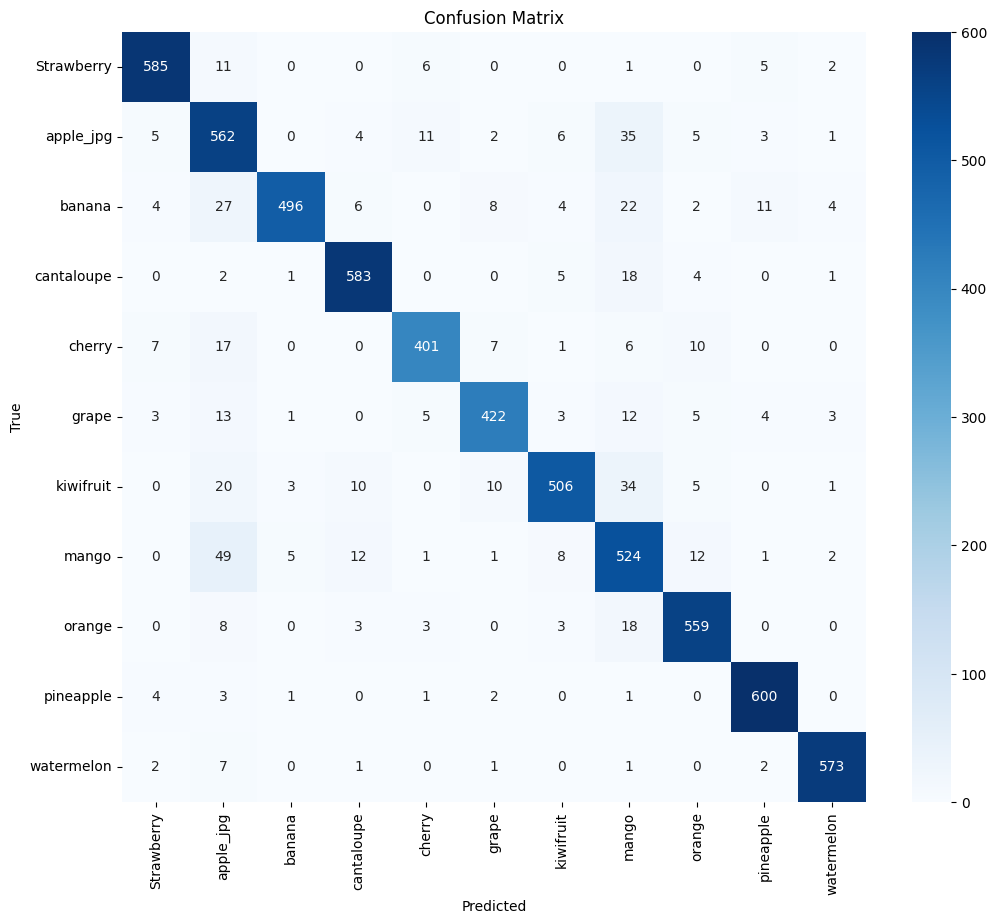

              precision    recall  f1-score   support

  Strawberry       0.96      0.96      0.96       610
   apple_jpg       0.78      0.89      0.83       634
      banana       0.98      0.85      0.91       584
  cantaloupe       0.94      0.95      0.95       614
      cherry       0.94      0.89      0.91       449
       grape       0.93      0.90      0.91       471
   kiwifruit       0.94      0.86      0.90       589
       mango       0.78      0.85      0.81       615
      orange       0.93      0.94      0.93       594
   pineapple       0.96      0.98      0.97       612
  watermelon       0.98      0.98      0.98       587

    accuracy                           0.91      6359
   macro avg       0.92      0.91      0.92      6359
weighted avg       0.92      0.91      0.91      6359



In [10]:
# Code for confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your validation data generator
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Get true labels
y_true = validation_generator.classes

# Predict on validation data
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Classification report
report = classification_report(y_true, y_pred, 
                              target_names=validation_generator.class_indices.keys())
print(report)
with open('classification_report.txt', 'w') as f:
    f.write(report)